# Track Analysis
Here we try to find the track's best racing line using different methods:
- low pass filter
- delta progress optimisation
- Euler's spirals (TODO)

## Import modules

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from deepracer.tracks import TrackIO, Track
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    AnalysisUtils as au, \
    PlottingUtils as pu

## Load track

In [2]:
!ls tracks/

AmericasGeneratedInclStart.npy	New_York_Eval_Track.npy
AWS_track.npy			New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			reInvent2019_track.npy
Canada_Training.npy		reInvent2019_wide_mirrored.npy
China_eval_track.npy		reInvent2019_wide.npy
China_track.npy			reinvent_base.npy
H_track.npy			Spain_track.npy
LGSWide.npy			Straight_track.npy
London_Loop_Train.npy		Tokyo_Training_track.npy
Mexico_track_eval.npy		Vegas_track.npy
Mexico_track.npy		Virtual_May19_Train_track.npy


In [3]:
tu = TrackIO()

In [4]:
track = tu.load_track("Spain_track")

Loaded 259 waypoints


# Choosing steering angles
Let's find most proper steering angles. We can use any method d_heading value.

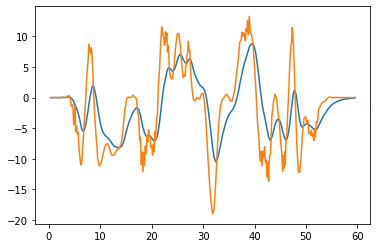

In [22]:
steering = np.array([t[:-1], np.degrees(dh)])
plt.plot(*steering)
plt.plot(t[:-1], np.degrees(d_heading))

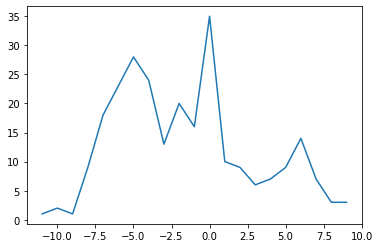

In [23]:
limit = np.arange(round(steering[1].min()), round(steering[1].max())+1)
pivot = np.array([len(steering.T[steering[1].round() == ang]) for ang in limit])
plt.plot(limit, pivot)

# Sector builder
Let's define sectors around the track. Mapping closest waypoint coordinates as a sector mark works well and can be used to construct interesting reward that stimulates improving every part of the track evenly.

In [5]:
def plot_track(t, fig=None):
    ratio = (lambda x,y: x / y)(*t.size())
    if fig is None:
        fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot()
    ax.axis('equal')
    ax.plot(*t.center_line.T, 'b')
    ax.plot(*t.outer_border.T, 'b')
    ax.plot(*t.inner_border.T, 'b')
    return ax

In [6]:
DENSITY = 2.0
key = lambda wpt: [int(round(c * DENSITY)) / DENSITY for c in wpt]
keys = np.array([key(w) for w in track.center_line])

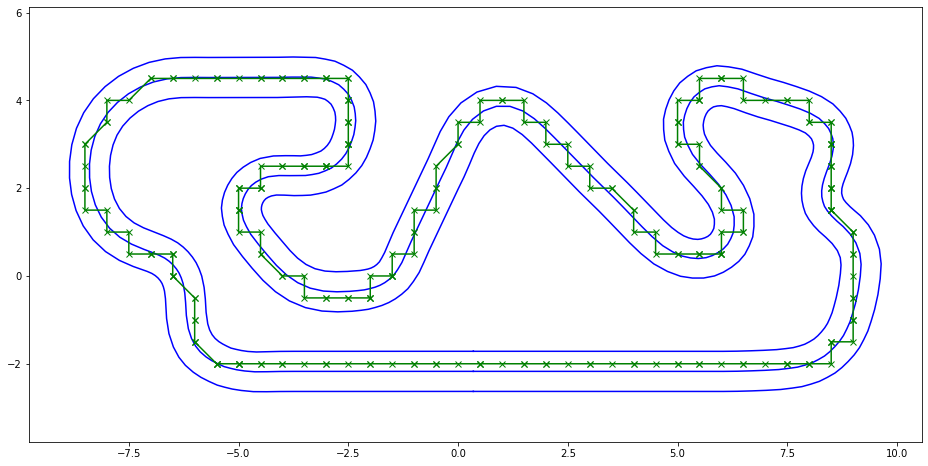

In [7]:
ax = plot_track(track)
ax.plot(*keys.T, 'gx-')

# PART 1: Low pass filter
Here we will try to get optimal path using a simple RC filter.

### Helpers

In [24]:
def track_distance(waypoints, i, N=1):
    next_waypoint = (i + N) % len(waypoints)
    A = np.array(waypoints[i])
    B = np.array(waypoints[next_waypoint])
    return np.linalg.norm(B - A) / N

In [25]:
def track_heading(waypoints, i, N=1, above=None, below=None):
    """
    Calculate track waypoints heading in radians.
    i : waypoint id
    N : waypoint look ahead
    above : indicies to tweak, values should be above PI
    below : indicies to tweak, values should be below PI
    """
    next_waypoint = (i + N) % len(waypoints)
    A = waypoints[i]
    B = waypoints[next_waypoint]
    t_heading = math.atan2(B[1] - A[1], B[0] - A[0])
    if above is not None and i in above and t_heading < 0:
        t_heading += math.pi*2
    if below is not None and i in below and t_heading > 0:
        t_heading -= math.pi*2
    return t_heading

In [26]:
def heading2track(heading, norms, w0, constant=None):
    """
    heading : polar coords angle
    norms : polar coords radius
    w0 : initial position
    """
    wpts = [np.array(w0)]
    for h,n in zip(heading, norms):
        polar = n * np.exp(1j * h)
        polar = np.array([np.real(polar), np.imag(polar)])
        if constant is not None:
            polar += constant * n
        wpts.append(np.array(wpts[-1]) + polar)
    return np.array(wpts[1:])

In [27]:
def int_heading(dheading, h0, dt, constant=0.0):
    ih = np.zeros(heading.shape)
    ih[0] = h0
    for i in range(0,len(dheading)):
        ih[i+1] = ih[i] + dheading[i] + constant * dt[i]
    return ih

### Analyze
Find a racing line.

#### Tune parameters above and below
Tune parameters so that the heading plot is continuous. Problem occurs at heading 180 deg, because it jumps to -180 deg, making it a non-differentiable step function.

In [28]:
above = list(range(0,25))
below = list(range(225,270)) + list(range(90,98))

In [29]:
ix = np.arange(len(track.center_line))
dt = np.array([track_distance(track.center_line, i, N=3) for i in ix])
t = np.cumsum(dt)
heading = np.array([track_heading(track.center_line, i, N=3, above=above, below=below) for i in ix])
d_heading = heading[1:] - heading[:-1]

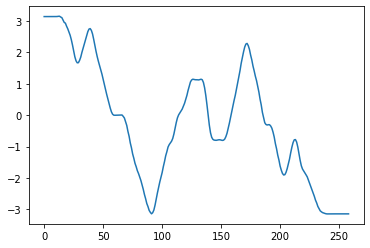

In [30]:
plt.plot(ix, heading)

#### Distance and distance derivative

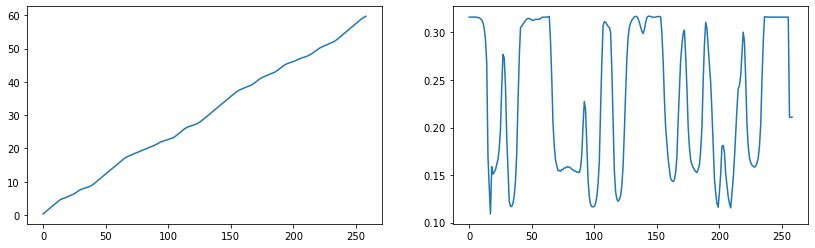

In [31]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(ix, t)
plt.subplot(122)
plt.plot(ix, dt)

#### After tuning
Plot heading over distance.

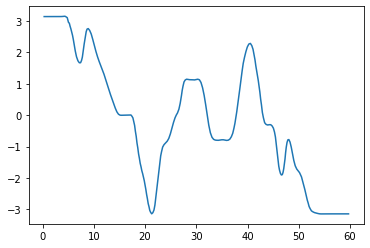

In [32]:
plt.plot(t, heading)

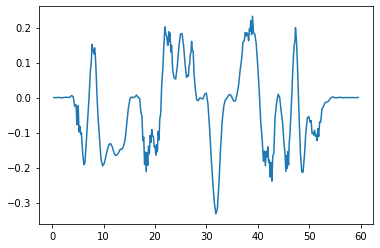

In [33]:
plt.plot(t[:-1], d_heading)

### Apply low-pass filter

In [34]:
def low_pass_filter(data, rc=1.0):
    xin = data[1]
    dt = data[0]
    alpha = dt / (rc + dt)
    yout = np.zeros(xin.shape)
    yout[0] = xin[0]
    for i in range(1,len(yout)):
        yout[i] = alpha[i] * xin[i] + (1.0 - alpha[i]) * yout[i-1]
    return yout

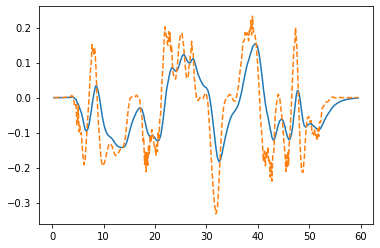

In [35]:
dh = d_heading
for i in range(0,1):
    dh = low_pass_filter([dt, dh], 1.5)
plt.plot(t[:-1], dh)
plt.plot(t[:-1], d_heading, '--')

In [36]:
hconst = 0.0 # heading constant
pconst = 0.0 # position constant
start = track.center_line[0] + np.array([0.0,0.0])
for i in [0,1,2]:
    i_heading = int_heading(dh, heading[0], dt, hconst)
    from_heading = heading2track(i_heading, dt, start, pconst)
    # Match first heading with last
    if i == 0:
        err = i_heading[0] - i_heading[-1]
        err = min(err, err - 2*math.pi)
        hconst = err / t[-1]
    # Match first position with last
    if i == 1:
        pconst = (from_heading[0] - from_heading[-1]) / t[-1]

YES, this is broken...
Please note that variable step is used here, which makes a big mess when looking for a constant offset. The problem is that because of variable step our constant is not... constant.. It's all difficult to solve at night, sorry...

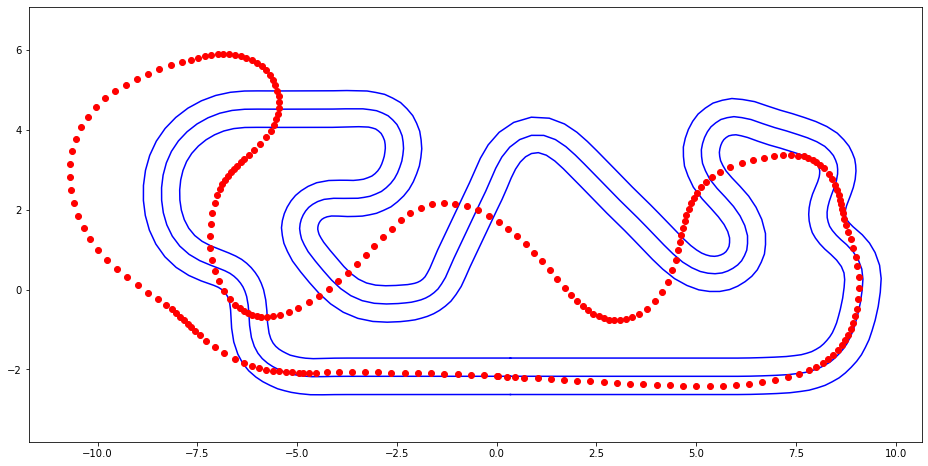

In [37]:
ax = plot_track(track)
ax.plot(*from_heading.T, 'ro')

# PART 2: Delta progress optimization
Now let's try finding a heading that minimizes travelled distance and maximizes track covered distance.

In [ ]:
def cost_delta():